**Run all the cells below to make sure everything is working and ready to go. All cells should run without error.**

# Import libraries

In [664]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
sys.path.append('/Users/prashun/anaconda/envs/carnd-term1/bin/python')
import cv2
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Helper Classes

In [665]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [666]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [667]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [668]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# changes to the draw lines to find average

In [669]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    # reshape lines to a 2d matrix
    lines = lines.reshape(lines.shape[0], lines.shape[2])
    # create array of slopes
    slopes = (lines[:,3] - lines[:,1]) /(lines[:,2] - lines[:,0])
    # remove junk from lists
    lines = lines[~np.isnan(lines) & ~np.isinf(lines)]
    slopes = slopes[~np.isnan(slopes) & ~np.isinf(slopes)]
    # convert lines into list of points
    lines.shape = (lines.shape[0]//2,2)

    # Right lane
    # move all points with negative slopes into right "lane"
    right_slopes = slopes[slopes < 0]
    right_lines = np.array(list(filter(lambda x: x[0] > (img.shape[1]/2), lines)))
    max_right_x, max_right_y = right_lines.max(axis=0)
    min_right_x, min_right_y = right_lines.min(axis=0)

    # Left lane
    # all positive  slopes go into left "lane"
    left_slopes = slopes[slopes > 0]
    left_lines = np.array(list(filter(lambda x: x[0] < (img.shape[1]/2), lines)))
    max_left_x, max_left_y = left_lines.max(axis=0)
    min_left_x, min_left_y = left_lines.min(axis=0)

    # Curve fitting approach
    # calculate polynomial fit for the points in right lane
    right_curve = np.poly1d(np.polyfit(right_lines[:,1], right_lines[:,0], 2))
    left_curve  = np.poly1d(np.polyfit(left_lines[:,1], left_lines[:,0], 2))

    # shared ceiling on the horizon for both lines
    min_y = min(min_left_y, min_right_y)

    # use new curve function f(y) to calculate x values
    max_right_x = int(right_curve(img.shape[0]))
    min_right_x = int(right_curve(min_right_y))

    min_left_x = int(left_curve(img.shape[0]))

    r1 = (min_right_x, min_y)
    r2 = (max_right_x, img.shape[0])
    print('Right points r1 and r2,', r1, r2)
    cv2.line(img, r1, r2, color, thickness)

    l1 = (max_left_x, min_y)
    l2 = (min_left_x, img.shape[0])
    print('Left points l1 and l2,', l1, l2)
    cv2.line(img, l1, l2, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


In [670]:
def weighted_img(img, initial_img, α=1.0, β=0.5, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# canny edge detection thresholds

In [671]:
low_threshold=120
high_threshold=150

# region of interest selection

In [672]:
### Params for region of interest
bot_left = [80, 540]
bot_right = [980, 540]
apex_right = [510, 315]
apex_left = [450, 315]
pts = np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)

# Hough transform params for the image 

In [673]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50 #minimum number of pixels making up a line
max_line_gap = 200   # maximum gap in pixels between connectable line segments

# Image Pieline Class

In [674]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    grey_scale_image=grayscale(image)
    gaussian_blured_image = gaussian_blur(grey_scale_image,5)
    canny_detected_image=canny(gaussian_blured_image,low_threshold,high_threshold)
    masked_gaussian_image = region_of_interest(canny_detected_image, [pts])
    hough_transform_image = hough_lines(masked_gaussian_image, rho, theta, threshold, min_line_length, max_line_gap)
    combo = weighted_img(hough_transform_image, image)
    return combo

# Main Class to loop through folder

solidWhiteCurve.jpg
Right points r1 and r2, (496, 315) (893, 540)
Left points l1 and l2, (460, 315) (216, 540)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidWhiteRight.jpg
Right points r1 and r2, (492, 315) (845, 540)
Left points l1 and l2, (476, 315) (153, 540)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowCurve.jpg
Right points r1 and r2, (491, 315) (851, 540)
Left points l1 and l2, (456, 315) (162, 540)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowCurve2.jpg
Right points r1 and r2, (508, 323) (866, 540)
Left points l1 and l2, (460, 323) (168, 540)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowLeft.jpg
Right points r1 and r2, (500, 315) (860, 540)
Left points l1 and l2, (460, 315) (153, 540)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
whiteCarLaneSwitch.jpg
Right points r1 and r2, (487, 315) (878, 540)
Left points l1 and l2, 

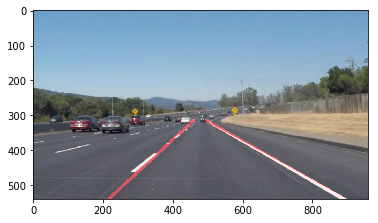

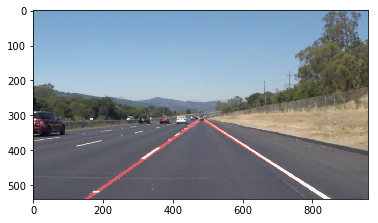

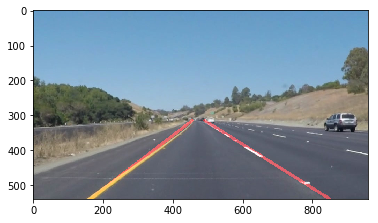

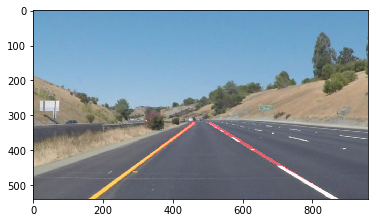

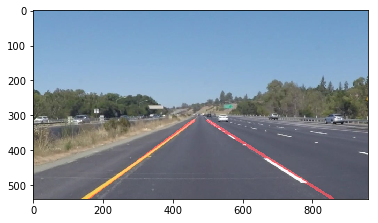

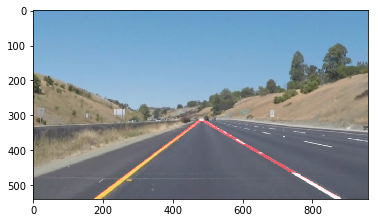

In [675]:
dirs = os.listdir("test_images/")
# This would print all the files and directories
for file in dirs:
    print(file)
    #reading in an image
    image = mpimg.imread('test_images/'+file)
    combo = process_image(image)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.figure()
    plt.imshow(combo)

In [676]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Right points r1 and r2, (494, 315) (855, 540)
Left points l1 and l2, (453, 315) (161, 540)
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4







  0%|          | 0/222 [00:00<?, ?it/s]




  1%|▏         | 3/222 [00:00<00:08, 24.86it/s]

Right points r1 and r2, (494, 315) (855, 540)
Left points l1 and l2, (453, 315) (161, 540)
Right points r1 and r2, (497, 315) (855, 540)
Left points l1 and l2, (455, 315) (156, 540)
Right points r1 and r2, (497, 315) (866, 540)
Left points l1 and l2, (455, 315) (153, 540)
Right points r1 and r2, (496, 315) (864, 540)
Left points l1 and l2, (455, 315) (157, 540)


Right points r1 and r2, (497, 315) (863, 540)
Left points l1 and l2, (453, 315) (158, 540)







  3%|▎         | 6/222 [00:00<00:08, 24.01it/s]




  4%|▍         | 9/222 [00:00<00:08, 25.20it/s]

Right points r1 and r2, (497, 315) (862, 540)
Left points l1 and l2, (454, 315) (123, 540)
Right points r1 and r2, (497, 315) (866, 540)
Left points l1 and l2, (454, 315) (102, 540)
Right points r1 and r2, (497, 315) (863, 540)
Left points l1 and l2, (455, 315) (160, 540)
Right points r1 and r2, (498, 315) (862, 540)
Left points l1 and l2, (455, 315) (147, 540)
Right points r1 and r2, (494, 315) (862, 540)
Left points l1 and l2, (475, 315) (184, 540)
Right points r1 and r2, (490, 315) (853, 540)
Left points l1 and l2, (462, 315) (148, 540)







  5%|▌         | 12/222 [00:00<00:08, 25.45it/s]




  7%|▋         | 15/222 [00:00<00:07, 25.99it/s]

Right points r1 and r2, (490, 315) (840, 540)
Left points l1 and l2, (474, 315) (168, 540)
Right points r1 and r2, (489, 315) (841, 540)
Left points l1 and l2, (473, 315) (149, 540)
Right points r1 and r2, (494, 315) (848, 540)
Left points l1 and l2, (453, 315) (149, 540)
Right points r1 and r2, (496, 315) (847, 540)
Left points l1 and l2, (452, 315) (150, 540)
Right points r1 and r2, (500, 315) (853, 540)
Left points l1 and l2, (452, 315) (147, 540)
Right points r1 and r2, (500, 315) (853, 540)
Left points l1 and l2, (451, 315) (142, 540)







  8%|▊         | 18/222 [00:00<00:08, 25.20it/s]




  9%|▉         | 21/222 [00:00<00:07, 26.09it/s]

Right points r1 and r2, (499, 315) (854, 540)
Left points l1 and l2, (451, 315) (207, 540)
Right points r1 and r2, (498, 315) (851, 540)
Left points l1 and l2, (454, 315) (137, 540)
Right points r1 and r2, (495, 315) (850, 540)
Left points l1 and l2, (449, 315) (103, 540)
Right points r1 and r2, (494, 316) (841, 540)
Left points l1 and l2, (449, 316) (81, 540)
Right points r1 and r2, (495, 315) (846, 540)
Left points l1 and l2, (475, 315) (157, 540)
Right points r1 and r2, (495, 316) (848, 540)
Left points l1 and l2, (452, 316) (112, 540)







 11%|█         | 24/222 [00:00<00:07, 25.33it/s]




 12%|█▏        | 27/222 [00:01<00:07, 25.53it/s]

Right points r1 and r2, (495, 315) (851, 540)
Left points l1 and l2, (454, 315) (166, 540)
Right points r1 and r2, (496, 315) (851, 540)
Left points l1 and l2, (454, 315) (148, 540)
Right points r1 and r2, (498, 315) (854, 540)
Left points l1 and l2, (457, 315) (149, 540)
Right points r1 and r2, (497, 315) (851, 540)
Left points l1 and l2, (456, 315) (149, 540)
Right points r1 and r2, (497, 315) (847, 540)
Left points l1 and l2, (452, 315) (153, 540)
Right points r1 and r2, (496, 315) (849, 540)
Left points l1 and l2, (475, 315) (155, 540)







 14%|█▎        | 30/222 [00:01<00:07, 25.23it/s]

Right points r1 and r2, (497, 315) (848, 540)
Left points l1 and l2, (455, 315) (171, 540)
Right points r1 and r2, (496, 315) (850, 540)
Left points l1 and l2, (457, 315) (290, 540)
Right points r1 and r2, (497, 315) (853, 540)
Left points l1 and l2, (456, 315) (133, 540)







 15%|█▍        | 33/222 [00:01<00:07, 24.43it/s]

Right points r1 and r2, (497, 315) (853, 540)
Left points l1 and l2, (456, 315) (141, 540)
Right points r1 and r2, (496, 315) (853, 540)
Left points l1 and l2, (456, 315) (123, 540)







 16%|█▌        | 36/222 [00:01<00:07, 23.97it/s]

Right points r1 and r2, (494, 315) (851, 540)
Left points l1 and l2, (455, 315) (208, 540)
Right points r1 and r2, (490, 315) (848, 540)
Left points l1 and l2, (475, 315) (140, 540)
Right points r1 and r2, (491, 315) (850, 540)
Left points l1 and l2, (453, 315) (150, 540)


Right points r1 and r2, (497, 315) (846, 540)
Left points l1 and l2, (475, 315) (157, 540)
Right points r1 and r2,






 18%|█▊        | 39/222 [00:01<00:08, 22.56it/s]




 19%|█▉        | 42/222 [00:01<00:07, 23.09it/s]

 (499, 315) (843, 540)
Left points l1 and l2, (454, 315) (150, 540)
Right points r1 and r2, (497, 315) (847, 540)
Left points l1 and l2, (453, 315) (155, 540)
Right points r1 and r2, (500, 315) (843, 540)
Left points l1 and l2, (452, 315) (151, 540)
Right points r1 and r2, (499, 315) (844, 540)
Left points l1 and l2, (455, 315) (104, 540)
Right points r1 and r2, (499, 315) (831, 540)
Left points l1 and l2, (454, 315) (168, 540)







 20%|██        | 45/222 [00:01<00:07, 23.33it/s]

Right points r1 and r2, (500, 315) (842, 540)
Left points l1 and l2, (456, 315) (139, 540)
Right points r1 and r2, (500, 315) (840, 540)
Left points l1 and l2, (455, 315) (149, 540)
Right points r1 and r2, (499, 315) (850, 540)
Left points l1 and l2, (455, 315) (193, 540)
Right points r1 and r2, (499, 315) (845, 540)
Left points l1 and l2, (454, 315) (167, 540)







 22%|██▏       | 48/222 [00:02<00:08, 21.23it/s]




 23%|██▎       | 51/222 [00:02<00:08, 20.11it/s]

Right points r1 and r2, (500, 315) (849, 540)
Left points l1 and l2, (452, 315) (154, 540)
Right points r1 and r2, (499, 315) (847, 540)
Left points l1 and l2, (452, 315) (154, 540)
Right points r1 and r2, (496, 315) (843, 540)
Left points l1 and l2, (452, 315) (147, 540)
Right points r1 and r2, (495, 315) (837, 540)
Left points l1 and l2, (451, 315) (147, 540)







 24%|██▍       | 54/222 [00:02<00:08, 20.20it/s]

Right points r1 and r2, (498, 315) (847, 540)
Left points l1 and l2, (451, 315) (145, 540)
Right points r1 and r2, (497, 315) (843, 540)
Left points l1 and l2, (450, 315) (143, 540)
Right points r1 and r2, (496, 315) (851, 540)
Left points l1 and l2, (454, 315) (131, 540)
Right points r1 and r2, (495, 315) (841, 540)
Left points l1 and l2, (455, 315) (161, 540)
Right points r1 and r2, (495, 315) (848, 540)
Left points l1 and l2, (462, 315) (119, 540)







 26%|██▌       | 57/222 [00:02<00:08, 19.20it/s]




 27%|██▋       | 59/222 [00:02<00:09, 17.45it/s]

Right points r1 and r2, (493, 315) (842, 540)
Left points l1 and l2, (462, 315) (137, 540)
Right points r1 and r2, (492, 316) (842, 540)
Left points l1 and l2, (474, 316) (162, 540)
Right points r1 and r2, (491, 315) (840, 540)
Left points l1 and l2, (453, 315) (208, 540)







 27%|██▋       | 61/222 [00:02<00:10, 15.74it/s]




 28%|██▊       | 63/222 [00:02<00:09, 16.45it/s]

Right points r1 and r2, (493, 315) (834, 540)
Left points l1 and l2, (473, 315) (144, 540)
Right points r1 and r2, (492, 315) (833, 540)
Left points l1 and l2, (474, 315) (138, 540)
Right points r1 and r2, (492, 315) (837, 540)
Left points l1 and l2, (474, 315) (137, 540)
Right points r1 and r2, (491, 315) (836, 540)
Left points l1 and l2, (471, 315) (140, 540)







 30%|██▉       | 66/222 [00:03<00:08, 17.41it/s]

Right points r1 and r2, (492, 317) (829, 540)
Left points l1 and l2, (454, 317) (137, 540)
Right points r1 and r2, (493, 316) (830, 540)
Left points l1 and l2, (453, 316) (132, 540)
Right points r1 and r2, (492, 315) (831, 540)
Left points l1 and l2, (453, 315) (47, 540)
Right points r1 and r2, (494, 315) (833, 540)
Left points l1 and l2, (451, 315) (107, 540)
Right points r1 and r2,






 31%|███       | 68/222 [00:03<00:09, 17.08it/s]




 32%|███▏      | 70/222 [00:03<00:08, 17.70it/s]

 (493, 315) (834, 540)
Left points l1 and l2, (454, 315) (129, 540)
Right points r1 and r2, (495, 315) (835, 540)
Left points l1 and l2, (453, 315) (118, 540)
Right points r1 and r2, (494, 315) (832, 540)
Left points l1 and l2, (472, 315) (107, 540)
Right points r1 and r2, (492, 315) (832, 540)
Left points l1 and l2, (452, 315) (115, 540)







 32%|███▏      | 72/222 [00:03<00:08, 17.83it/s]




 34%|███▍      | 75/222 [00:03<00:08, 18.37it/s]

Right points r1 and r2, (496, 315) (831, 540)
Left points l1 and l2, (451, 315) (174, 540)
Right points r1 and r2, (492, 315) (831, 540)
Left points l1 and l2, (452, 315) (128, 540)
Right points r1 and r2, (493, 315) (831, 540)
Left points l1 and l2, (471, 315) (134, 540)
Right points r1 and r2, (492, 315) (834, 540)
Left points l1 and l2, (449, 315) (134, 540)
Right points r1 and r2, (495, 316) (837, 540)
Left points l1 and l2, (450, 316) (127, 540)







 35%|███▍      | 77/222 [00:03<00:07, 18.65it/s]




 36%|███▌      | 80/222 [00:03<00:07, 19.22it/s]

Right points r1 and r2, (494, 316) (834, 540)
Left points l1 and l2, (449, 316) (127, 540)
Right points r1 and r2, (494, 315) (830, 540)
Left points l1 and l2, (448, 315) (204, 540)
Right points r1 and r2, (495, 315) (827, 540)
Left points l1 and l2, (446, 315) (119, 540)
Right points r1 and r2, (495, 316) (824, 540)
Left points l1 and l2, (451, 316) (129, 540)
Right points r1 and r2, (494, 315) (822, 540)
Left points l1 and l2, (445, 315) (132, 540)







 37%|███▋      | 83/222 [00:03<00:06, 19.98it/s]

Right points r1 and r2, (494, 315) (822, 540)
Left points l1 and l2, (450, 315) (56, 540)
Right points r1 and r2, (493, 316) (824, 540)
Left points l1 and l2, (452, 316) (143, 540)
Right points r1 and r2, (494, 315) (827, 540)
Left points l1 and l2, (452, 315) (113, 540)
Right points r1 and r2, (496, 315) (828, 540)
Left points l1 and l2, (451, 315) (188, 540)
Right points r1 and r2, (495, 315) (821, 540)
Left points l1 and l2, (450, 315) (120, 540)







 39%|███▊      | 86/222 [00:04<00:06, 19.92it/s]




 40%|████      | 89/222 [00:04<00:06, 20.45it/s]

Right points r1 and r2, (490, 315) (822, 540)
Left points l1 and l2, (451, 315) (120, 540)
Right points r1 and r2, (493, 316) (820, 540)
Left points l1 and l2, (450, 316) (128, 540)
Right points r1 and r2, (498, 315) (821, 540)
Left points l1 and l2, (472, 315) (127, 540)
Right points r1 and r2, (492, 315) (820, 540)
Left points l1 and l2, (450, 315) (144, 540)
Right points r1 and r2, (493, 315) (817, 540)
Left points l1 and l2, (463, 315) (95, 540)







 41%|████▏     | 92/222 [00:04<00:06, 19.97it/s]




 43%|████▎     | 95/222 [00:04<00:06, 20.68it/s]

Right points r1 and r2, (496, 315) (822, 540)
Left points l1 and l2, (449, 315) (134, 540)
Right points r1 and r2, (495, 315) (820, 540)
Left points l1 and l2, (455, 315) (128, 540)
Right points r1 and r2, (497, 315) (824, 540)
Left points l1 and l2, (455, 315) (367, 540)
Right points r1 and r2, (494, 315) (823, 540)
Left points l1 and l2, (458, 315) (141, 540)
Right points r1 and r2, (502, 315) (821, 540)
Left points l1 and l2, (455, 315) (114, 540)







 44%|████▍     | 98/222 [00:04<00:06, 20.64it/s]




 45%|████▌     | 101/222 [00:04<00:05, 21.03it/s]

Right points r1 and r2, (505, 315) (824, 540)
Left points l1 and l2, (454, 315) (117, 540)
Right points r1 and r2, (502, 316) (823, 540)
Left points l1 and l2, (455, 316) (143, 540)
Right points r1 and r2, (500, 315) (822, 540)
Left points l1 and l2, (453, 315) (122, 540)
Right points r1 and r2, (502, 315) (822, 540)
Left points l1 and l2, (457, 315) (120, 540)
Right points r1 and r2, (502, 315) (826, 540)
Left points l1 and l2, (456, 315) (128, 540)







 47%|████▋     | 104/222 [00:04<00:05, 20.77it/s]

Right points r1 and r2, (499, 315) (825, 540)
Left points l1 and l2, (457, 315) (88, 540)
Right points r1 and r2, (500, 315) (825, 540)
Left points l1 and l2, (455, 315) (90, 540)
Right points r1 and r2, (497, 316) (825, 540)
Left points l1 and l2, (457, 316) (128, 540)
Right points r1 and r2, (499, 315) (824, 540)
Left points l1 and l2, (474, 315) (121, 540)
Right points r1 and r2, (498, 315) (830, 540)
Left points l1 and l2, (458, 315) (74, 540)







 48%|████▊     | 107/222 [00:05<00:05, 20.51it/s]




 50%|████▉     | 110/222 [00:05<00:05, 20.12it/s]

Right points r1 and r2, (501, 315) (827, 540)
Left points l1 and l2, (457, 315) (127, 540)
Right points r1 and r2, (500, 315) (832, 540)
Left points l1 and l2, (457, 315) (126, 540)
Right points r1 and r2, (499, 315) (828, 540)
Left points l1 and l2, (456, 315) (124, 540)
Right points r1 and r2, (504, 317) (827, 540)
Left points l1 and l2, (456, 317) (140, 540)







 51%|█████     | 113/222 [00:05<00:05, 18.77it/s]

Right points r1 and r2, (504, 318) (832, 540)
Left points l1 and l2, (455, 318) (133, 540)
Right points r1 and r2, (499, 315) (835, 540)
Left points l1 and l2, (474, 315) (141, 540)
Right points r1 and r2, (499, 315) (823, 540)
Left points l1 and l2, (454, 315) (139, 540)
Right points r1 and r2, (499, 315) (829, 540)
Left points l1 and l2, (473, 315) (202, 540)







 52%|█████▏    | 115/222 [00:05<00:05, 18.77it/s]




 53%|█████▎    | 118/222 [00:05<00:05, 19.19it/s]

Right points r1 and r2, (501, 315) (840, 540)
Left points l1 and l2, (453, 315) (145, 540)
Right points r1 and r2, (497, 315) (835, 540)
Left points l1 and l2, (457, 315) (153, 540)
Right points r1 and r2, (496, 315) (835, 540)
Left points l1 and l2, (451, 315) (136, 540)
Right points r1 and r2, (496, 315) (836, 540)
Left points l1 and l2, (459, 315) (136, 540)
Right points r1 and r2, (500, 315) (843, 540)
Left points l1 and l2, (476, 315) (196, 540)







 54%|█████▍    | 120/222 [00:05<00:05, 19.18it/s]




 55%|█████▌    | 123/222 [00:05<00:04, 19.90it/s]

Right points r1 and r2, (497, 315) (841, 540)
Left points l1 and l2, (458, 315) (152, 540)
Right points r1 and r2, (498, 315) (839, 540)
Left points l1 and l2, (475, 315) (138, 540)
Right points r1 and r2, (492, 316) (838, 540)
Left points l1 and l2, (475, 316) (142, 540)
Right points r1 and r2, (497, 315) (847, 540)
Left points l1 and l2, (475, 315) (136, 540)
Right points r1 and r2, (495, 315) (845, 540)
Left points l1 and l2, (476, 315) (132, 540)







 57%|█████▋    | 126/222 [00:06<00:04, 20.23it/s]




 58%|█████▊    | 129/222 [00:06<00:04, 20.73it/s]

Right points r1 and r2, (495, 315) (837, 540)
Left points l1 and l2, (476, 315) (135, 540)
Right points r1 and r2, (497, 315) (841, 540)
Left points l1 and l2, (455, 315) (-114, 540)
Right points r1 and r2, (497, 315) (853, 540)
Left points l1 and l2, (454, 315) (114, 540)
Right points r1 and r2, (503, 320) (850, 540)
Left points l1 and l2, (459, 320) (115, 540)
Right points r1 and r2, (496, 315) (853, 540)
Left points l1 and l2, (475, 315) (140, 540)







 59%|█████▉    | 132/222 [00:06<00:04, 19.70it/s]

Right points r1 and r2, (494, 315) (849, 540)
Left points l1 and l2, (458, 315) (135, 540)
Right points r1 and r2, (495, 316) (844, 540)
Left points l1 and l2, (476, 316) (172, 540)
Right points r1 and r2, (495, 315) (849, 540)
Left points l1 and l2, (475, 315) (180, 540)
Right points r1 and r2, (498, 315) (850, 540)
Left points l1 and l2, (475, 315) (148, 540)
Right points r1 and r2, (498, 315) (851, 540)
Left points l1 and l2, (459, 315) (148, 540)







 60%|██████    | 134/222 [00:06<00:04, 19.72it/s]




 62%|██████▏   | 137/222 [00:06<00:04, 19.79it/s]

Right points r1 and r2, (501, 315) (851, 540)
Left points l1 and l2, (460, 315) (155, 540)
Right points r1 and r2, (499, 315) (851, 540)
Left points l1 and l2, (458, 315) (146, 540)
Right points r1 and r2, (501, 315) (859, 540)
Left points l1 and l2, (461, 315) (150, 540)
Right points r1 and r2, (503, 315) (859, 540)
Left points l1 and l2, (460, 315) (36, 540)
Right points r1 and r2, (500, 315) (850, 540)
Left points l1 and l2, (465, 315) 






 63%|██████▎   | 139/222 [00:06<00:04, 19.75it/s]




 64%|██████▍   | 142/222 [00:06<00:04, 19.98it/s]

(163, 540)
Right points r1 and r2, (497, 316) (850, 540)
Left points l1 and l2, (459, 316) (173, 540)
Right points r1 and r2, (495, 315) (848, 540)
Left points l1 and l2, (455, 315) (147, 540)
Right points r1 and r2, (497, 316) (846, 540)
Left points l1 and l2, (464, 316) (157, 540)
Right points r1 and r2, (496, 315) (852, 540)
Left points l1 and l2, (476, 315) (195, 540)
Right points r1 and r2, (496, 315) (850, 540)
Left points l1 and l2, (475, 315) (228, 540)







 65%|██████▌   | 145/222 [00:07<00:03, 19.88it/s]




 66%|██████▌   | 147/222 [00:07<00:03, 19.83it/s]

Right points r1 and r2, (501, 316) (850, 540)
Left points l1 and l2, (459, 316) (149, 540)
Right points r1 and r2, (500, 316) (853, 540)
Left points l1 and l2, (458, 316) (153, 540)
Right points r1 and r2, (505, 318) (861, 540)
Left points l1 and l2, (458, 318) (153, 540)
Right points r1 and r2, (500, 315) (859, 540)
Left points l1 and l2, (457, 315) (154, 540)







 67%|██████▋   | 149/222 [00:07<00:04, 17.07it/s]




 68%|██████▊   | 152/222 [00:07<00:04, 17.23it/s]

Right points r1 and r2, (508, 316) (868, 540)
Left points l1 and l2, (456, 316) (159, 540)
Right points r1 and r2, (496, 315) (866, 540)
Left points l1 and l2, (456, 315) (153, 540)
Right points r1 and r2, (502, 316) (864, 540)
Left points l1 and l2, (462, 316) (165, 540)
Right points r1 and r2, (502, 316) (855, 540)
Left points l1 and l2, (476, 316) (174, 540)







 69%|██████▉   | 154/222 [00:07<00:04, 16.22it/s]

Right points r1 and r2, (496, 315) (859, 540)
Left points l1 and l2, (469, 315) (171, 540)
Right points r1 and r2, (503, 315) (859, 540)
Left points l1 and l2, (467, 315) (159, 540)
Right points r1 and r2, (501, 315) (861, 540)
Left points l1 and l2, (452, 315) (134, 540)
Right points r1 and r2, (501, 315) (859, 540)
Left points l1 and l2, (460, 315) (149, 540)
Right points r1 and r2, (501, 315) (857, 540)







 71%|███████   | 157/222 [00:07<00:03, 17.41it/s]




 72%|███████▏  | 159/222 [00:07<00:03, 17.96it/s]

Left points l1 and l2, (460, 315) (159, 540)
Right points r1 and r2, (502, 315) (860, 540)
Left points l1 and l2, (459, 315) (161, 540)
Right points r1 and r2, (503, 315) (870, 540)
Left points l1 and l2, (456, 315) (161, 540)
Right points r1 and r2, (501, 316) (873, 540)
Left points l1 and l2, (458, 316) (166, 540)
Right points r1 and r2, (500, 315) (876, 540)
Left points l1 and l2, (470, 315) (165, 540)







 73%|███████▎  | 162/222 [00:07<00:03, 18.80it/s]




 74%|███████▍  | 164/222 [00:08<00:03, 17.81it/s]

Right points r1 and r2, (496, 315) (875, 540)
Left points l1 and l2, (476, 315) (185, 540)
Right points r1 and r2, (495, 315) (877, 540)
Left points l1 and l2, (476, 315) (152, 540)
Right points r1 and r2, (497, 315) (880, 540)
Left points l1 and l2, (470, 315) (145, 540)
Right points r1 and r2, (497, 315) (883, 540)
Left points l1 and l2, (471, 315) (175, 540)







 75%|███████▍  | 166/222 [00:08<00:03, 17.60it/s]




 76%|███████▌  | 168/222 [00:08<00:03, 16.47it/s]

Right points r1 and r2, (499, 315) (881, 540)
Left points l1 and l2, (476, 315) (181, 540)
Right points r1 and r2, (494, 315) (879, 540)
Left points l1 and l2, (460, 315) (121, 540)
Right points r1 and r2, (496, 315) (883, 540)
Left points l1 and l2, (471, 315) (157, 540)
Right points r1 and r2, (496, 315) (872, 540)
Left points l1 and l2, (471, 315) (168, 540)







 77%|███████▋  | 171/222 [00:08<00:02, 17.66it/s]




 78%|███████▊  | 173/222 [00:08<00:02, 18.19it/s]

Right points r1 and r2, (494, 315) (874, 540)
Left points l1 and l2, (470, 315) (175, 540)
Right points r1 and r2, (492, 315) (875, 540)
Left points l1 and l2, (471, 315) (184, 540)
Right points r1 and r2, (494, 315) (878, 540)
Left points l1 and l2, (473, 315) (179, 540)
Right points r1 and r2, (499, 315) (880, 540)
Left points l1 and l2, (476, 315) (178, 540)
Right points r1 and r2, (499, 316) (874, 540)
Left points l1 and l2, (456, 316) (111, 540)







 79%|███████▉  | 176/222 [00:08<00:02, 18.76it/s]




 81%|████████  | 179/222 [00:08<00:02, 19.66it/s]

Right points r1 and r2, (496, 315) (875, 540)
Left points l1 and l2, (456, 315) (136, 540)
Right points r1 and r2, (494, 315) (880, 540)
Left points l1 and l2, (462, 315) (161, 540)
Right points r1 and r2, (493, 315) (873, 540)
Left points l1 and l2, (461, 315) (178, 540)
Right points r1 and r2, (493, 315) (876, 540)
Left points l1 and l2, (475, 315) (180, 540)
Right points r1 and r2, (499, 315) (877, 540)
Left points l1 and l2, (474, 315) (312, 540)







 82%|████████▏ | 181/222 [00:08<00:02, 19.49it/s]

Right points r1 and r2, (498, 315) (879, 540)
Left points l1 and l2, (476, 315) (179, 540)
Right points r1 and r2, (497, 315) (878, 540)
Left points l1 and l2, (461, 315) (197, 540)
Right points r1 and r2, (497, 315) (882, 540)
Left points l1 and l2, (475, 315) (190, 540)
Right points r1 and r2, (500, 315) (881, 540)
Left points l1 and l2, (464, 315) (191, 540)
Right points r1 and r2, (497, 315) (882, 540)
Left points l1 and l2, (462, 315) (189, 540)







 83%|████████▎ | 184/222 [00:09<00:01, 19.83it/s]




 84%|████████▍ | 187/222 [00:09<00:01, 17.80it/s]

Right points r1 and r2, (499, 315) (886, 540)
Left points l1 and l2, (458, 315) (187, 540)
Right points r1 and r2, (501, 315) (876, 540)
Left points l1 and l2, (458, 315) (183, 540)
Right points r1 and r2, (497, 315) (879, 540)
Left points l1 and l2, (462, 315) (208, 540)
Right points r1 and r2, (504, 315) (897, 540)
Left points l1 and l2, (456, 315) (192, 540)







 85%|████████▌ | 189/222 [00:09<00:01, 17.09it/s]




 86%|████████▌ | 191/222 [00:09<00:01, 17.28it/s]

Right points r1 and r2, (504, 316) (887, 540)
Left points l1 and l2, (460, 316) (196, 540)
Right points r1 and r2, (506, 315) (894, 540)
Left points l1 and l2, (457, 315) (178, 540)
Right points r1 and r2, (504, 315) (896, 540)
Left points l1 and l2, (460, 315) (204, 540)
Right points r1 and r2, (501, 315) (892, 540)
Left points l1 and l2, (460, 315) (175, 540)







 87%|████████▋ | 193/222 [00:09<00:01, 17.85it/s]




 88%|████████▊ | 196/222 [00:09<00:01, 18.83it/s]

Right points r1 and r2, (499, 315) (886, 540)
Left points l1 and l2, (460, 315) (150, 540)
Right points r1 and r2, (497, 315) (882, 540)
Left points l1 and l2, (459, 315) (199, 540)
Right points r1 and r2, (492, 315) (876, 540)
Left points l1 and l2, (457, 315) (183, 540)
Right points r1 and r2, (494, 315) (878, 540)
Left points l1 and l2, (477, 315) (184, 540)
Right points r1 and r2, (497, 316) (877, 540)
Left points l1 and l2, (457, 316) (181, 540)







 89%|████████▉ | 198/222 [00:09<00:01, 18.91it/s]




 91%|█████████ | 201/222 [00:10<00:01, 19.34it/s]

Right points r1 and r2, (496, 315) (886, 540)
Left points l1 and l2, (474, 315) (259, 540)
Right points r1 and r2, (500, 315) (884, 540)
Left points l1 and l2, (475, 315) (264, 540)
Right points r1 and r2, (497, 315) (879, 540)
Left points l1 and l2, (475, 315) (197, 540)
Right points r1 and r2, (494, 315) (888, 540)
Left points l1 and l2, (476, 315) (202, 540)







 91%|█████████▏| 203/222 [00:10<00:01, 17.34it/s]

Right points r1 and r2, (496, 315) (878, 540)
Left points l1 and l2, (464, 315) (191, 540)
Right points r1 and r2, (498, 315) (887, 540)
Left points l1 and l2, (476, 315) (256, 540)
Right points r1 and r2, (495, 315) (891, 540)
Left points l1 and l2, (457, 315) (164, 540)
Right points r1 and r2, (500, 315) (899, 540)
Left points l1 and l2, (464, 315) (207, 540)







 92%|█████████▏| 205/222 [00:10<00:01, 16.27it/s]




 93%|█████████▎| 207/222 [00:10<00:00, 16.71it/s]




 94%|█████████▍| 209/222 [00:10<00:00, 16.46it/s]

Right points r1 and r2, (501, 315) (888, 540)
Left points l1 and l2, (463, 315) (184, 540)
Right points r1 and r2, (503, 316) (893, 540)
Left points l1 and l2, (463, 316) (182, 540)
Right points r1 and r2, (504, 315) (903, 540)
Left points l1 and l2, (463, 315) (185, 540)
Right points r1 and r2, (503, 315) (901, 540)
Left points l1 and l2, (465, 315) (188, 540)







 95%|█████████▌| 211/222 [00:10<00:00, 13.53it/s]

Right points r1 and r2, (502, 316) (894, 540)
Left points l1 and l2, (462, 316) (182, 540)
Right points r1 and r2, (497, 315) (893, 540)
Left points l1 and l2, (461, 315) (214, 540)
Right points r1 and r2, (497, 315) (891, 540)
Left points l1 and l2, (462, 315) (206, 540)







 96%|█████████▌| 213/222 [00:10<00:00, 14.60it/s]




 97%|█████████▋| 216/222 [00:11<00:00, 16.24it/s]

Right points r1 and r2, (495, 315) (891, 540)
Left points l1 and l2, (459, 315) (199, 540)
Right points r1 and r2, (496, 315) (892, 540)
Left points l1 and l2, (458, 315) (186, 540)
Right points r1 and r2, (495, 315) (892, 540)
Left points l1 and l2, (460, 315) (198, 540)
Right points r1 and r2, (496, 315) (895, 540)
Left points l1 and l2, (459, 315) (176, 540)
Right points r1 and r2, (493, 315) (888, 540)
Left points l1 and l2, (456, 315) (182, 540)







 98%|█████████▊| 218/222 [00:11<00:00, 14.75it/s]




 99%|█████████▉| 220/222 [00:11<00:00, 13.58it/s]

Right points r1 and r2, (498, 316) (885, 540)
Left points l1 and l2, (459, 316) (190, 540)
Right points r1 and r2, (496, 315) (884, 540)
Left points l1 and l2, (463, 315) (183, 540)
Right points r1 and r2, (491, 315) (889, 540)
Left points l1 and l2, (479, 315) (186, 540)







100%|█████████▉| 221/222 [00:11<00:00, 19.25it/s]

Right points r1 and r2, (495, 317) (894, 540)
Left points l1 and l2, (461, 317) (187, 540)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.8 s, sys: 977 ms, total: 8.77 s
Wall time: 12.8 s


In [677]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))